# Hyperpigmentation Detection System

This notebook implements a comprehensive hyperpigmentation detection system using deep learning models. The system processes original facial images and green-annotated hyperpigmentation masks to train various segmentation models.

## Features:
- Multiple preprocessing techniques for facial images
- Green color segmentation for annotation masks
- Multiple model architectures (U-Net, DeepLabV3+, SegNet)
- Comprehensive evaluation metrics
- Real-time inference pipeline


In [1]:
# Install required packages
!pip install opencv-contrib-python-headless==4.8.0.74
!pip install --upgrade --force-reinstall mediapipe==0.10.15
!pip install tensorflow==2.15.0  # Changed from 2.16.2 to 2.15.0 for compatibility
!pip install segmentation-models
!pip install albumentations
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 8.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.4 MB

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.15 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
gradio 5.49.1 requires pillow<12.

In [2]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt: 

In [ ]:
!pip install opencv-contrib-python-headless==4.8.0.74

ERROR: Operation cancelled by user


In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization,
    ReLU, Multiply, Input, GlobalAveragePooling2D, Dense,
    Activation, MaxPooling2D, Dropout, Add, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from PIL import Image
import matplotlib.pyplot as plt
import mediapipe as mp
import albumentations as A
from sklearn.model_selection import train_test_split
import json
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def detect_face(image):
    """ Detect face using MediaPipe Face Detection """
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.detections:
            detection = results.detections[0]  # Get the first (most confident) detection
            return detection
    return None

def get_face_bbox(image, detection):
    """Extract face bounding box from detection."""
    h, w = image.shape[:2]
    bbox = detection.location_data.relative_bounding_box

    # Convert relative coordinates to absolute coordinates
    x = int(bbox.xmin * w)
    y = int(bbox.ymin * h)
    width = int(bbox.width * w)
    height = int(bbox.height * h)

    return x, y, width, height


In [3]:
# Data Preprocessing Functions

def extract_green_mask(image):
    """
    Extract green-colored hyperpigmentation annotations from the image
    """
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range for green color in HSV
    # Green in HSV: H=60-120, S=100-255, V=100-255
    lower_green = np.array([40, 50, 50])   # Lower bound for green
    upper_green = np.array([80, 255, 255])  # Upper bound for green

    # Create mask for green regions
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)

    return green_mask

def enhance_image(image):
    """
    Apply various enhancement techniques to improve hyperpigmentation visibility
    """
    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge channels and convert back to BGR
    enhanced_lab = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)

    return filtered

def crop_face(image, detection):
    """
    Crop image to face region using face detection
    """
    h, w = image.shape[:2]
    x, y, width, height = get_face_bbox(image, detection)

    # Add padding around the face
    padding = 20
    x = max(0, x - padding)
    y = max(0, y - padding)
    width = min(w - x, width + 2 * padding)
    height = min(h - y, height + 2 * padding)

    # Crop image
    cropped_image = image[y:y+height, x:x+width]

    bbox = (x, y, x+width, y+height)
    return cropped_image, bbox


In [4]:
# Data Augmentation Pipeline

def get_augmentation_pipeline():
    """
    Define augmentation pipeline for training data
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    ])

def apply_augmentation(image, mask, augmentation):
    """
    Apply augmentation to image and mask
    """
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']


In [5]:
# FIXED: Spatial Attention Layer (use this instead of the function in cell above)
# Add this class definition and replace the spatial_attention function

class SpatialAttentionLayer(tf.keras.layers.Layer):
    """
    Spatial attention mechanism as a Layer
    """
    def __init__(self, **kwargs):
        super(SpatialAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, 7, padding='same', activation='sigmoid')
        super(SpatialAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute average and max pooling along channel dimension
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        # Concatenate along channel dimension
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        # Apply convolution to get spatial attention map
        sa = self.conv(concat)
        # Apply attention to input
        return Multiply()([x, sa])

# Replace the spatial_attention function in the previous cell with:
# def spatial_attention(x):
#     """
#     Spatial attention mechanism
#     """
#     return SpatialAttentionLayer()(x)


In [6]:
# Dataset Preparation

IMG_SIZE = (256, 256)

def preprocess_image(image_path, mask_path, n_classes=1, apply_augmentation_flag=False):
    """
    Preprocess image and mask for training
    """
    # Read image
    image = cv2.imread(image_path.numpy().decode('utf-8'))
    if image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32), \
               np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)

    # Enhance image
    image = enhance_image(image)

    # Read mask
    mask = cv2.imread(mask_path.numpy().decode('utf-8'), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error: Could not read mask file at path: {mask_path}")
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32), \
               np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)

    # Resize
    image = cv2.resize(image, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    # Normalize image
    image = image.astype(np.float32) / 255.0

    # Process mask
    if n_classes == 1:
        mask = (mask > 127).astype(np.float32)
        mask = mask[..., None]
    else:
        mask = mask.astype(np.uint8)
        mask = mask[..., None]

    return image, mask

def tf_preprocess_image(image_path, mask_path, n_classes=1, apply_augmentation_flag=False):
    """
    TensorFlow wrapper for preprocessing
    """
    image, mask = tf.py_function(
        func=preprocess_image,
        inp=[image_path, mask_path, n_classes, apply_augmentation_flag],
        Tout=[tf.float32, tf.float32]
    )
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return image, mask

def get_dataset(image_dir, mask_dir, batch_size=8, n_classes=1, apply_augmentation_flag=False):
    """
    Create TensorFlow dataset
    """
    # Get all file paths
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(OUTPUT_IMAGES_PATH)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(OUTPUT_MASKS_PATH)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Ensure same number of files
    min_files = min(len(image_files), len(mask_files))
    image_files = image_files[:min_files]
    mask_files = mask_files[:min_files]

    if min_files == 0:
        print("Error: No preprocessed images or masks found. Please ensure preprocessing ran successfully and check paths.")
        return None, None

    # Split file paths into training and validation sets
    # Check if we have enough samples for splitting
    if min_files < 2: # If less than 2 samples, train_test_split might lead to empty sets
        print(f"Warning: Only {min_files} samples available. Skipping train/val split and using all data for training.")
        train_image_files, train_mask_files = image_files, mask_files
        val_image_files, val_mask_files = [], [] # No validation set
    else:
        train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
            image_files, mask_files, test_size=0.2, random_state=42
        )

    # Create TensorFlow datasets from split file paths
    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))
    train_dataset = train_dataset.map(
        lambda x, y: tf_preprocess_image(x, y, N_CLASSES, True), # apply_augmentation_flag=True
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_mask_files))
    val_dataset = val_dataset.map(
        lambda x, y: tf_preprocess_image(x, y, N_CLASSES, False), # No augmentation for validation
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset


In [7]:
# Model Architectures

class AttentionBlock(tf.keras.layers.Layer):
    """
    Attention block for U-Net
    """
    def __init__(self, filters, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.theta = Conv2D(self.filters, 1, padding='same')
        self.phi = Conv2D(self.filters, 1, padding='same')
        self.psi = Conv2D(1, 1, padding='same', activation='sigmoid')

    def call(self, x, g):
        theta_x = self.theta(x)
        phi_g = self.phi(g)
        f = Activation('relu')(Add()([theta_x, phi_g]))
        psi_f = self.psi(f)
        return Multiply()([x, psi_f])

def conv_block(x, filters, kernel_size=3, padding='same'):
    """
    Convolutional block with batch normalization and ReLU
    """
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def spatial_attention(x):
    """
    Spatial attention mechanism
    """
    avg_pool = Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    sa = Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return Multiply()([x, sa])

def build_unet_model(input_shape=(256, 256, 3)):
    """
    Build U-Net model with attention mechanisms
    """
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    conv1 = conv_block(conv1, 64)
    pool1 = MaxPooling2D()(conv1)

    conv2 = conv_block(pool1, 128)
    conv2 = conv_block(conv2, 128)
    pool2 = MaxPooling2D()(conv2)

    conv3 = conv_block(pool2, 256)
    conv3 = conv_block(conv3, 256)
    pool3 = MaxPooling2D()(conv3)

    conv4 = conv_block(pool3, 512)
    conv4 = conv_block(conv4, 512)
    pool4 = MaxPooling2D()(conv4)

    # Bottleneck
    bneck = conv_block(pool4, 1024)
    bneck = conv_block(bneck, 1024)
    bneck = spatial_attention(bneck)

    # Decoder with attention
    up4 = Conv2DTranspose(512, 2, strides=2, padding='same')(bneck)
    attn4 = AttentionBlock(512)(conv4, up4)
    merge4 = Concatenate()([up4, attn4])
    conv5 = conv_block(merge4, 512)
    conv5 = conv_block(conv5, 512)

    up3 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    attn3 = AttentionBlock(256)(conv3, up3)
    merge3 = Concatenate()([up3, attn3])
    conv6 = conv_block(merge3, 256)
    conv6 = conv_block(conv6, 256)

    up2 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    attn2 = AttentionBlock(128)(conv2, up2)
    merge2 = Concatenate()([up2, attn2])
    conv7 = conv_block(merge2, 128)
    conv7 = conv_block(conv7, 128)

    up1 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    attn1 = AttentionBlock(64)(conv1, up1)
    merge1 = Concatenate()([up1, attn1])
    conv8 = conv_block(merge1, 64)
    conv8 = conv_block(conv8, 64)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(conv8)

    model = Model(inputs, outputs, name='Attention_UNet')
    return model


In [8]:
# FIXED: Focal Loss Function (fixes shape error)
# Replace the focal_loss function in the previous cell with this version:

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal loss for handling class imbalance - FIXED VERSION
    """
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

    # Compute binary crossentropy manually to preserve spatial dimensions
    # This fixes the shape mismatch error
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

    focal_loss = alpha_t * tf.pow((1 - p_t), gamma) * bce
    return tf.reduce_mean(focal_loss)

# Also update combined_loss to use the fixed version:
def combined_loss(y_true, y_pred):
    """
    Combined loss function - FIXED VERSION
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)  # Use fixed version
    return bce + dice + 0.5 * focal

print("Fixed loss functions defined. Replace focal_loss and combined_loss in the previous cell with these versions.")


Fixed loss functions defined. Replace focal_loss and combined_loss in the previous cell with these versions.


In [9]:
# # Additional Model Architectures

# def build_deeplabv3_plus(input_shape=(256, 256, 3)):
#     """
#     Build DeepLabV3+ model
#     """
#     # This is a simplified version - for full implementation, use segmentation-models library
#     base_model = tf.keras.applications.ResNet50(
#         input_shape=input_shape,
#         include_top=False,
#         weights='imagenet'
#     )

#     # ASPP (Atrous Spatial Pyramid Pooling)
#     x = base_model.output

#     # Global average pooling
#     gap = GlobalAveragePooling2D()(x)
#     gap = Dense(256, activation='relu')(gap)
#     gap = tf.keras.layers.Reshape((1, 1, 256))(gap)
#     gap = Conv2DTranspose(256, 32, strides=32, padding='same')(gap)

#     # Atrous convolutions
#     atrous1 = Conv2D(256, 1, padding='same', activation='relu')(x)
#     atrous2 = Conv2D(256, 3, padding='same', dilation_rate=6, activation='relu')(x)
#     atrous3 = Conv2D(256, 3, padding='same', dilation_rate=12, activation='relu')(x)
#     atrous4 = Conv2D(256, 3, padding='same', dilation_rate=18, activation='relu')(x)

#     # Concatenate
#     x = Concatenate()([atrous1, atrous2, atrous3, atrous4, gap])
#     x = Conv2D(256, 1, padding='same', activation='relu')(x)

#     # Decoder
#     x = Conv2DTranspose(256, 4, strides=4, padding='same')(x)

#     # Skip connection
#     skip = Conv2D(48, 1, padding='same')(base_model.get_layer('conv2_block3_2_relu').output)
#     x = Concatenate()([x, skip])

#     x = Conv2D(256, 3, padding='same', activation='relu')(x)
#     x = Conv2DTranspose(256, 4, strides=4, padding='same')(x)

#     # Output
#     outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(x)

#     model = Model(base_model.input, outputs, name='DeepLabV3Plus')
#     return model

# def build_segnet(input_shape=(256, 256, 3)):
#     """
#     Build SegNet model
#     """
#     inputs = Input(shape=input_shape)

#     # Encoder
#     conv1 = conv_block(inputs, 64)
#     conv1 = conv_block(conv1, 64)
#     pool1 = MaxPooling2D()(conv1)

#     conv2 = conv_block(pool1, 128)
#     conv2 = conv_block(conv2, 128)
#     pool2 = MaxPooling2D()(conv2)

#     conv3 = conv_block(pool2, 256)
#     conv3 = conv_block(conv3, 256)
#     pool3 = MaxPooling2D()(conv3)

#     conv4 = conv_block(pool3, 512)
#     conv4 = conv_block(conv4, 512)
#     pool4 = MaxPooling2D()(conv4)

#     # Bottleneck
#     conv5 = conv_block(pool4, 1024)
#     conv5 = conv_block(conv5, 1024)

#     # Decoder
#     up4 = Conv2DTranspose(512, 2, strides=2, padding='same')(conv5)
#     conv6 = conv_block(up4, 512)
#     conv6 = conv_block(conv6, 512)

#     up3 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv6)
#     conv7 = conv_block(up3, 256)
#     conv7 = conv_block(conv7, 256)

#     up2 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv7)
#     conv8 = conv_block(up2, 128)
#     conv8 = conv_block(conv8, 128)

#     up1 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv8)
#     conv9 = conv_block(up1, 64)
#     conv9 = conv_block(conv9, 64)

#     # Output
#     outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)

#     model = Model(inputs, outputs, name='SegNet')
#     return model


In [10]:
# Loss Functions and Metrics

def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for segmentation
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient metric
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Intersection over Union metric
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [11]:
# Training Configuration

# Define paths (update these according to your data structure)
ORIGINAL_IMAGES_PATH = "/content/drive/MyDrive/Hyperpigmentation /Original photo"
ANNOTATED_IMAGES_PATH = "/content/drive/MyDrive/Hyperpigmentation /Annotated"
OUTPUT_IMAGES_PATH = "/content/drive/MyDrive/Dataset/Hyperpigmentation_Cropped_Images"
OUTPUT_MASKS_PATH = "/content/drive/MyDrive/Dataset/Hyperpigmentation_Cropped_Masks"

# Training parameters
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 1e-4
IMG_SIZE = (256, 256)
N_CLASSES = 1

# Create output directories
os.makedirs(OUTPUT_IMAGES_PATH, exist_ok=True)
os.makedirs(OUTPUT_MASKS_PATH, exist_ok=True)

print("Configuration set up successfully!")


Configuration set up successfully!


In [12]:
# Data Preprocessing Pipeline

def preprocess_dataset(original_path, annotated_path, output_img_path, output_mask_path):
    """
    Preprocess the entire dataset
    """
    print("Starting dataset preprocessing...")

    # Process annotated images to extract green masks
    for filename in os.listdir(annotated_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(annotated_path, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Could not read image: {filename}")
                continue

            # Detect face
            detection = detect_face(image)
            if detection is None:
                print(f"Could not detect face for: {filename}")
                continue

            # Crop to face region
            cropped_img, bbox = crop_face(image, detection)
            if cropped_img is None:
                print(f"Could not crop image: {filename}")
                continue

            # Extract green mask
            green_mask = extract_green_mask(cropped_img)

            # Save cropped mask
            mask_path = os.path.join(output_mask_path, filename)
            cv2.imwrite(mask_path, green_mask)

            print(f"Processed mask: {filename}")

    # Process original images
    for filename in os.listdir(original_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(original_path, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Could not read image: {filename}")
                continue

            # Detect face
            detection = detect_face(image)
            if detection is None:
                print(f"Could not detect face for: {filename}")
                continue

            # Crop to face region
            cropped_img, bbox = crop_face(image, detection)
            if cropped_img is None:
                print(f"Could not crop image: {filename}")
                continue

            # Save cropped image
            img_output_path = os.path.join(output_img_path, filename)
            cv2.imwrite(img_output_path, cropped_img)

            print(f"Processed image: {filename}")

    print("Dataset preprocessing completed!")

# Uncomment the line below to run preprocessing
preprocess_dataset(ORIGINAL_IMAGES_PATH, ANNOTATED_IMAGES_PATH, OUTPUT_IMAGES_PATH, OUTPUT_MASKS_PATH)


Starting dataset preprocessing...
Could not detect face for: IMG_0214.JPG
Could not detect face for: IMG_0213.JPG
Processed mask: IMG_9919.JPG
Processed mask: IMG_0193.JPG
Processed mask: IMG_9918.JPG
Could not detect face for: IMG_0214.JPG
Could not detect face for: IMG_0213.JPG
Processed image: IMG_9919.JPG
Processed image: IMG_0193.JPG
Processed image: IMG_9918.JPG
Dataset preprocessing completed!


In [13]:
# Model Training

def train_model(model_name='unet'):
    """
    Train the selected model
    """
    train_dataset, val_dataset = get_dataset(OUTPUT_IMAGES_PATH, OUTPUT_MASKS_PATH)

    # Build model
    if model_name == 'unet':
        model = build_unet_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    # elif model_name == 'deeplabv3':
    #     model = build_deeplabv3_plus(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    # elif model_name == 'segnet':
    #     model = build_segnet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=combined_loss,
        metrics=['accuracy', dice_coefficient, iou_metric]
    )

    # Callbacks
    callbacks = []
    fit_kwargs = {}
    if val_dataset:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True))
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7))
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(
            f'hyperpigmentation_{model_name}_best.h5',
            monitor='val_loss',
            save_best_only=True
        ))
        fit_kwargs['validation_data'] = val_dataset
    else:
        print("No validation data available, training without validation set.")
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(
            f'hyperpigmentation_{model_name}_best.h5',
            monitor='loss', # Monitor training loss when no val data
            save_best_only=True
        ))

    # Train model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
        **fit_kwargs
    )

    return model, history

# Train different models
print("Training U-Net model...")
unet_model, unet_history = train_model('unet')

# print("\nTraining DeepLabV3+ model...")
# deeplab_model, deeplab_history = train_model('deeplabv3')

# print("\nTraining SegNet model...")
# segnet_model, segnet_history = train_model('segnet')

Training U-Net model...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.7438 - dice_coefficient: 0.0606 - iou_metric: 0.0313 - loss: 1.5399

1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.7438 - dice_coefficient: 0.0606 - iou_metric: 0.0313 - loss: 1.5399 - val_accuracy: 0.7798 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.7134 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.8049 - dice_coefficient: 0.0715 - iou_metric: 0.0371 - loss: 1.4852 - val_accuracy: 0.8168 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7136 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.8405 - dice_coefficient: 0.0812 - iou_metric: 0.0423 - loss: 1.4505

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.8405 - dice_coefficient: 0.0812 - iou_metric: 0.0423 - loss: 1.4505 - val_accuracy: 0.9025 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7130 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8636 - dice_coefficient: 0.0897 - iou_metric: 0.0469 - loss: 1.4232

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.8636 - dice_coefficient: 0.0897 - iou_metric: 0.0469 - loss: 1.4232 - val_accuracy: 0.9493 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7121 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8830 - dice_coefficient: 0.0978 - iou_metric: 0.0514 - loss: 1.3984

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.8830 - dice_coefficient: 0.0978 - iou_metric: 0.0514 - loss: 1.3984 - val_accuracy: 0.9655 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7109 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.8998 - dice_coefficient: 0.1054 - iou_metric: 0.0556 - loss: 1.3766

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.8998 - dice_coefficient: 0.1054 - iou_metric: 0.0556 - loss: 1.3766 - val_accuracy: 0.9710 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7098 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.9146 - dice_coefficient: 0.1127 - iou_metric: 0.0597 - loss: 1.3560

1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.9146 - dice_coefficient: 0.1127 - iou_metric: 0.0597 - loss: 1.3560 - val_accuracy: 0.9746 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7088 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9269 - dice_coefficient: 0.1202 - iou_metric: 0.0639 - loss: 1.3359

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9269 - dice_coefficient: 0.1202 - iou_metric: 0.0639 - loss: 1.3359 - val_accuracy: 0.9763 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.7077 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9364 - dice_coefficient: 0.1278 - iou_metric: 0.0682 - loss: 1.3163

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.9364 - dice_coefficient: 0.1278 - iou_metric: 0.0682 - loss: 1.3163 - val_accuracy: 0.9773 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.7066 - learning_rate: 1.0000e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9446 - dice_coefficient: 0.1358 - iou_metric: 0.0728 - loss: 1.2966

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.9446 - dice_coefficient: 0.1358 - iou_metric: 0.0728 - loss: 1.2966 - val_accuracy: 0.9778 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.7053 - learning_rate: 1.0000e-04
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9517 - dice_coefficient: 0.1439 - iou_metric: 0.0775 - loss: 1.2769

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.9517 - dice_coefficient: 0.1439 - iou_metric: 0.0775 - loss: 1.2769 - val_accuracy: 0.9782 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.7039 - learning_rate: 1.0000e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9573 - dice_coefficient: 0.1521 - iou_metric: 0.0823 - loss: 1.2570

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9573 - dice_coefficient: 0.1521 - iou_metric: 0.0823 - loss: 1.2570 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.7024 - learning_rate: 1.0000e-04
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.9626 - dice_coefficient: 0.1601 - iou_metric: 0.0870 - loss: 1.2372

1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.9626 - dice_coefficient: 0.1601 - iou_metric: 0.0870 - loss: 1.2372 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.7007 - learning_rate: 1.0000e-04
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9674 - dice_coefficient: 0.1675 - iou_metric: 0.0914 - loss: 1.2177

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9674 - dice_coefficient: 0.1675 - iou_metric: 0.0914 - loss: 1.2177 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0415 - val_iou_metric: 0.0212 - val_loss: 1.6990 - learning_rate: 1.0000e-04
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9722 - dice_coefficient: 0.1741 - iou_metric: 0.0953 - loss: 1.1986

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9722 - dice_coefficient: 0.1741 - iou_metric: 0.0953 - loss: 1.1986 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6970 - learning_rate: 1.0000e-04
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9763 - dice_coefficient: 0.1800 - iou_metric: 0.0989 - loss: 1.1796

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9763 - dice_coefficient: 0.1800 - iou_metric: 0.0989 - loss: 1.1796 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6950 - learning_rate: 1.0000e-04
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9805 - dice_coefficient: 0.1856 - iou_metric: 0.1023 - loss: 1.1606

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9805 - dice_coefficient: 0.1856 - iou_metric: 0.1023 - loss: 1.1606 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6927 - learning_rate: 1.0000e-04
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9834 - dice_coefficient: 0.1909 - iou_metric: 0.1055 - loss: 1.1417

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9834 - dice_coefficient: 0.1909 - iou_metric: 0.1055 - loss: 1.1417 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6903 - learning_rate: 1.0000e-04
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9858 - dice_coefficient: 0.1964 - iou_metric: 0.1089 - loss: 1.1227

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9858 - dice_coefficient: 0.1964 - iou_metric: 0.1089 - loss: 1.1227 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6877 - learning_rate: 1.0000e-04
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9873 - dice_coefficient: 0.2023 - iou_metric: 0.1125 - loss: 1.1035

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9873 - dice_coefficient: 0.2023 - iou_metric: 0.1125 - loss: 1.1035 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0212 - val_loss: 1.6850 - learning_rate: 1.0000e-04
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9884 - dice_coefficient: 0.2086 - iou_metric: 0.1164 - loss: 1.0844

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9884 - dice_coefficient: 0.2086 - iou_metric: 0.1164 - loss: 1.0844 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6821 - learning_rate: 1.0000e-04
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9893 - dice_coefficient: 0.2150 - iou_metric: 0.1204 - loss: 1.0656

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9893 - dice_coefficient: 0.2150 - iou_metric: 0.1204 - loss: 1.0656 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6790 - learning_rate: 1.0000e-04
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9901 - dice_coefficient: 0.2215 - iou_metric: 0.1245 - loss: 1.0472

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9901 - dice_coefficient: 0.2215 - iou_metric: 0.1245 - loss: 1.0472 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6758 - learning_rate: 1.0000e-04
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9909 - dice_coefficient: 0.2281 - iou_metric: 0.1287 - loss: 1.0292

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9909 - dice_coefficient: 0.2281 - iou_metric: 0.1287 - loss: 1.0292 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6724 - learning_rate: 1.0000e-04
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9915 - dice_coefficient: 0.2348 - iou_metric: 0.1330 - loss: 1.0117

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.9915 - dice_coefficient: 0.2348 - iou_metric: 0.1330 - loss: 1.0117 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6690 - learning_rate: 1.0000e-04
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9918 - dice_coefficient: 0.2417 - iou_metric: 0.1374 - loss: 0.9948

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9918 - dice_coefficient: 0.2417 - iou_metric: 0.1374 - loss: 0.9948 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6654 - learning_rate: 1.0000e-04
Epoch 27/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9922 - dice_coefficient: 0.2485 - iou_metric: 0.1418 - loss: 0.9785

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9922 - dice_coefficient: 0.2485 - iou_metric: 0.1418 - loss: 0.9785 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6617 - learning_rate: 1.0000e-04
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9927 - dice_coefficient: 0.2552 - iou_metric: 0.1463 - loss: 0.9629

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9927 - dice_coefficient: 0.2552 - iou_metric: 0.1463 - loss: 0.9629 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6578 - learning_rate: 1.0000e-04
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9931 - dice_coefficient: 0.2619 - iou_metric: 0.1507 - loss: 0.9478

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9931 - dice_coefficient: 0.2619 - iou_metric: 0.1507 - loss: 0.9478 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6539 - learning_rate: 1.0000e-04
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9933 - dice_coefficient: 0.2687 - iou_metric: 0.1552 - loss: 0.9334

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.9933 - dice_coefficient: 0.2687 - iou_metric: 0.1552 - loss: 0.9334 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0414 - val_iou_metric: 0.0211 - val_loss: 1.6500 - learning_rate: 1.0000e-04
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9936 - dice_coefficient: 0.2753 - iou_metric: 0.1596 - loss: 0.9196

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9936 - dice_coefficient: 0.2753 - iou_metric: 0.1596 - loss: 0.9196 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6459 - learning_rate: 1.0000e-04
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9939 - dice_coefficient: 0.2818 - iou_metric: 0.1640 - loss: 0.9065

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9939 - dice_coefficient: 0.2818 - iou_metric: 0.1640 - loss: 0.9065 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6418 - learning_rate: 1.0000e-04
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9941 - dice_coefficient: 0.2881 - iou_metric: 0.1683 - loss: 0.8939

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9941 - dice_coefficient: 0.2881 - iou_metric: 0.1683 - loss: 0.8939 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6375 - learning_rate: 1.0000e-04
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9945 - dice_coefficient: 0.2942 - iou_metric: 0.1724 - loss: 0.8819

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.9945 - dice_coefficient: 0.2942 - iou_metric: 0.1724 - loss: 0.8819 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6333 - learning_rate: 1.0000e-04
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9948 - dice_coefficient: 0.3002 - iou_metric: 0.1766 - loss: 0.8705

1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.9948 - dice_coefficient: 0.3002 - iou_metric: 0.1766 - loss: 0.8705 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6290 - learning_rate: 1.0000e-04
Epoch 36/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9949 - dice_coefficient: 0.3060 - iou_metric: 0.1806 - loss: 0.8597

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9949 - dice_coefficient: 0.3060 - iou_metric: 0.1806 - loss: 0.8597 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6247 - learning_rate: 1.0000e-04
Epoch 37/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9952 - dice_coefficient: 0.3117 - iou_metric: 0.1846 - loss: 0.8493

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9952 - dice_coefficient: 0.3117 - iou_metric: 0.1846 - loss: 0.8493 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6203 - learning_rate: 1.0000e-04
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9955 - dice_coefficient: 0.3173 - iou_metric: 0.1885 - loss: 0.8394

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9955 - dice_coefficient: 0.3173 - iou_metric: 0.1885 - loss: 0.8394 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0413 - val_iou_metric: 0.0211 - val_loss: 1.6159 - learning_rate: 1.0000e-04
Epoch 39/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9957 - dice_coefficient: 0.3226 - iou_metric: 0.1923 - loss: 0.8300

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9957 - dice_coefficient: 0.3226 - iou_metric: 0.1923 - loss: 0.8300 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0211 - val_loss: 1.6114 - learning_rate: 1.0000e-04
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9960 - dice_coefficient: 0.3277 - iou_metric: 0.1960 - loss: 0.8211

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.9960 - dice_coefficient: 0.3277 - iou_metric: 0.1960 - loss: 0.8211 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.6069 - learning_rate: 1.0000e-04
Epoch 41/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9961 - dice_coefficient: 0.3327 - iou_metric: 0.1996 - loss: 0.8126

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9961 - dice_coefficient: 0.3327 - iou_metric: 0.1996 - loss: 0.8126 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.6025 - learning_rate: 1.0000e-04
Epoch 42/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9963 - dice_coefficient: 0.3375 - iou_metric: 0.2030 - loss: 0.8045

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9963 - dice_coefficient: 0.3375 - iou_metric: 0.2030 - loss: 0.8045 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.5979 - learning_rate: 1.0000e-04
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9964 - dice_coefficient: 0.3421 - iou_metric: 0.2063 - loss: 0.7969

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9964 - dice_coefficient: 0.3421 - iou_metric: 0.2063 - loss: 0.7969 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.5934 - learning_rate: 1.0000e-04
Epoch 44/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9967 - dice_coefficient: 0.3464 - iou_metric: 0.2095 - loss: 0.7896

1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.9967 - dice_coefficient: 0.3464 - iou_metric: 0.2095 - loss: 0.7896 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.5887 - learning_rate: 1.0000e-04
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9968 - dice_coefficient: 0.3507 - iou_metric: 0.2127 - loss: 0.7827

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9968 - dice_coefficient: 0.3507 - iou_metric: 0.2127 - loss: 0.7827 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0412 - val_iou_metric: 0.0210 - val_loss: 1.5841 - learning_rate: 1.0000e-04
Epoch 46/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9970 - dice_coefficient: 0.3547 - iou_metric: 0.2156 - loss: 0.7761

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9970 - dice_coefficient: 0.3547 - iou_metric: 0.2156 - loss: 0.7761 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5792 - learning_rate: 1.0000e-04
Epoch 47/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9971 - dice_coefficient: 0.3587 - iou_metric: 0.2186 - loss: 0.7699

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9971 - dice_coefficient: 0.3587 - iou_metric: 0.2186 - loss: 0.7699 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5748 - learning_rate: 1.0000e-04
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9971 - dice_coefficient: 0.3617 - iou_metric: 0.2208 - loss: 0.7648

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9971 - dice_coefficient: 0.3617 - iou_metric: 0.2208 - loss: 0.7648 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5692 - learning_rate: 1.0000e-04
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9969 - dice_coefficient: 0.3634 - iou_metric: 0.2221 - loss: 0.7620

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9969 - dice_coefficient: 0.3634 - iou_metric: 0.2221 - loss: 0.7620 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5651 - learning_rate: 1.0000e-04
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9962 - dice_coefficient: 0.3680 - iou_metric: 0.2255 - loss: 0.7563

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9962 - dice_coefficient: 0.3680 - iou_metric: 0.2255 - loss: 0.7563 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5599 - learning_rate: 1.0000e-04
Epoch 51/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9977 - dice_coefficient: 0.3720 - iou_metric: 0.2285 - loss: 0.7481

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9977 - dice_coefficient: 0.3720 - iou_metric: 0.2285 - loss: 0.7481 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0411 - val_iou_metric: 0.0210 - val_loss: 1.5545 - learning_rate: 1.0000e-04
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9971 - dice_coefficient: 0.3750 - iou_metric: 0.2308 - loss: 0.7445

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9971 - dice_coefficient: 0.3750 - iou_metric: 0.2308 - loss: 0.7445 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0210 - val_loss: 1.5501 - learning_rate: 1.0000e-04
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9977 - dice_coefficient: 0.3795 - iou_metric: 0.2342 - loss: 0.7375

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9977 - dice_coefficient: 0.3795 - iou_metric: 0.2342 - loss: 0.7375 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0209 - val_loss: 1.5457 - learning_rate: 1.0000e-04
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9975 - dice_coefficient: 0.3816 - iou_metric: 0.2358 - loss: 0.7339

1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.9975 - dice_coefficient: 0.3816 - iou_metric: 0.2358 - loss: 0.7339 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0209 - val_loss: 1.5403 - learning_rate: 1.0000e-04
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9974 - dice_coefficient: 0.3861 - iou_metric: 0.2392 - loss: 0.7281

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9974 - dice_coefficient: 0.3861 - iou_metric: 0.2392 - loss: 0.7281 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0209 - val_loss: 1.5349 - learning_rate: 1.0000e-04
Epoch 56/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9978 - dice_coefficient: 0.3885 - iou_metric: 0.2411 - loss: 0.7238

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9978 - dice_coefficient: 0.3885 - iou_metric: 0.2411 - loss: 0.7238 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0209 - val_loss: 1.5302 - learning_rate: 1.0000e-04
Epoch 57/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9983 - dice_coefficient: 0.3912 - iou_metric: 0.2432 - loss: 0.7190

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9983 - dice_coefficient: 0.3912 - iou_metric: 0.2432 - loss: 0.7190 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0410 - val_iou_metric: 0.0209 - val_loss: 1.5257 - learning_rate: 1.0000e-04
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9978 - dice_coefficient: 0.3950 - iou_metric: 0.2461 - loss: 0.7144

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9978 - dice_coefficient: 0.3950 - iou_metric: 0.2461 - loss: 0.7144 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0409 - val_iou_metric: 0.0209 - val_loss: 1.5206 - learning_rate: 1.0000e-04
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9977 - dice_coefficient: 0.3981 - iou_metric: 0.2486 - loss: 0.7101

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9977 - dice_coefficient: 0.3981 - iou_metric: 0.2486 - loss: 0.7101 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0409 - val_iou_metric: 0.0209 - val_loss: 1.5152 - learning_rate: 1.0000e-04
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9984 - dice_coefficient: 0.4003 - iou_metric: 0.2502 - loss: 0.7058

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9984 - dice_coefficient: 0.4003 - iou_metric: 0.2502 - loss: 0.7058 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0409 - val_iou_metric: 0.0209 - val_loss: 1.5102 - learning_rate: 1.0000e-04
Epoch 61/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9984 - dice_coefficient: 0.4032 - iou_metric: 0.2525 - loss: 0.7017

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9984 - dice_coefficient: 0.4032 - iou_metric: 0.2525 - loss: 0.7017 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0409 - val_iou_metric: 0.0209 - val_loss: 1.5055 - learning_rate: 1.0000e-04
Epoch 62/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9981 - dice_coefficient: 0.4065 - iou_metric: 0.2551 - loss: 0.6977

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9981 - dice_coefficient: 0.4065 - iou_metric: 0.2551 - loss: 0.6977 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0408 - val_iou_metric: 0.0208 - val_loss: 1.5003 - learning_rate: 1.0000e-04
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9983 - dice_coefficient: 0.4088 - iou_metric: 0.2569 - loss: 0.6938

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9983 - dice_coefficient: 0.4088 - iou_metric: 0.2569 - loss: 0.6938 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0408 - val_iou_metric: 0.0208 - val_loss: 1.4950 - learning_rate: 1.0000e-04
Epoch 64/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9985 - dice_coefficient: 0.4115 - iou_metric: 0.2590 - loss: 0.6899

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9985 - dice_coefficient: 0.4115 - iou_metric: 0.2590 - loss: 0.6899 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0408 - val_iou_metric: 0.0208 - val_loss: 1.4898 - learning_rate: 1.0000e-04
Epoch 65/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9984 - dice_coefficient: 0.4142 - iou_metric: 0.2612 - loss: 0.6863

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.9984 - dice_coefficient: 0.4142 - iou_metric: 0.2612 - loss: 0.6863 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0408 - val_iou_metric: 0.0208 - val_loss: 1.4847 - learning_rate: 1.0000e-04
Epoch 66/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.9986 - dice_coefficient: 0.4166 - iou_metric: 0.2631 - loss: 0.6826

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9986 - dice_coefficient: 0.4166 - iou_metric: 0.2631 - loss: 0.6826 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0407 - val_iou_metric: 0.0208 - val_loss: 1.4797 - learning_rate: 1.0000e-04
Epoch 67/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9987 - dice_coefficient: 0.4190 - iou_metric: 0.2650 - loss: 0.6791

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9987 - dice_coefficient: 0.4190 - iou_metric: 0.2650 - loss: 0.6791 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0407 - val_iou_metric: 0.0208 - val_loss: 1.4746 - learning_rate: 1.0000e-04
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.9986 - dice_coefficient: 0.4217 - iou_metric: 0.2672 - loss: 0.6756

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.9986 - dice_coefficient: 0.4217 - iou_metric: 0.2672 - loss: 0.6756 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0407 - val_iou_metric: 0.0208 - val_loss: 1.4693 - learning_rate: 1.0000e-04
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9987 - dice_coefficient: 0.4239 - iou_metric: 0.2690 - loss: 0.6722

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9987 - dice_coefficient: 0.4239 - iou_metric: 0.2690 - loss: 0.6722 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0407 - val_iou_metric: 0.0207 - val_loss: 1.4641 - learning_rate: 1.0000e-04
Epoch 70/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9988 - dice_coefficient: 0.4263 - iou_metric: 0.2709 - loss: 0.6689

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9988 - dice_coefficient: 0.4263 - iou_metric: 0.2709 - loss: 0.6689 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0406 - val_iou_metric: 0.0207 - val_loss: 1.4592 - learning_rate: 1.0000e-04
Epoch 71/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9988 - dice_coefficient: 0.4286 - iou_metric: 0.2728 - loss: 0.6656

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9988 - dice_coefficient: 0.4286 - iou_metric: 0.2728 - loss: 0.6656 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0406 - val_iou_metric: 0.0207 - val_loss: 1.4542 - learning_rate: 1.0000e-04
Epoch 72/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.9989 - dice_coefficient: 0.4309 - iou_metric: 0.2746 - loss: 0.6625

1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.9989 - dice_coefficient: 0.4309 - iou_metric: 0.2746 - loss: 0.6625 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0406 - val_iou_metric: 0.0207 - val_loss: 1.4489 - learning_rate: 1.0000e-04
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9989 - dice_coefficient: 0.4331 - iou_metric: 0.2764 - loss: 0.6594

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.9989 - dice_coefficient: 0.4331 - iou_metric: 0.2764 - loss: 0.6594 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0405 - val_iou_metric: 0.0207 - val_loss: 1.4437 - learning_rate: 1.0000e-04
Epoch 74/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.9990 - dice_coefficient: 0.4352 - iou_metric: 0.2781 - loss: 0.6563

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.9990 - dice_coefficient: 0.4352 - iou_metric: 0.2781 - loss: 0.6563 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0405 - val_iou_metric: 0.0207 - val_loss: 1.4389 - learning_rate: 1.0000e-04
Epoch 75/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9989 - dice_coefficient: 0.4375 - iou_metric: 0.2800 - loss: 0.6534

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9989 - dice_coefficient: 0.4375 - iou_metric: 0.2800 - loss: 0.6534 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0405 - val_iou_metric: 0.0207 - val_loss: 1.4339 - learning_rate: 1.0000e-04
Epoch 76/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9990 - dice_coefficient: 0.4394 - iou_metric: 0.2816 - loss: 0.6505

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9990 - dice_coefficient: 0.4394 - iou_metric: 0.2816 - loss: 0.6505 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0404 - val_iou_metric: 0.0206 - val_loss: 1.4288 - learning_rate: 1.0000e-04
Epoch 77/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9990 - dice_coefficient: 0.4416 - iou_metric: 0.2834 - loss: 0.6476

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9990 - dice_coefficient: 0.4416 - iou_metric: 0.2834 - loss: 0.6476 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0404 - val_iou_metric: 0.0206 - val_loss: 1.4239 - learning_rate: 1.0000e-04
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9991 - dice_coefficient: 0.4435 - iou_metric: 0.2849 - loss: 0.6448

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.9991 - dice_coefficient: 0.4435 - iou_metric: 0.2849 - loss: 0.6448 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0404 - val_iou_metric: 0.0206 - val_loss: 1.4191 - learning_rate: 1.0000e-04
Epoch 79/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9990 - dice_coefficient: 0.4457 - iou_metric: 0.2868 - loss: 0.6421

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.9990 - dice_coefficient: 0.4457 - iou_metric: 0.2868 - loss: 0.6421 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0403 - val_iou_metric: 0.0206 - val_loss: 1.4140 - learning_rate: 1.0000e-04
Epoch 80/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.9992 - dice_coefficient: 0.4472 - iou_metric: 0.2880 - loss: 0.6395

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.9992 - dice_coefficient: 0.4472 - iou_metric: 0.2880 - loss: 0.6395 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0403 - val_iou_metric: 0.0206 - val_loss: 1.4094 - learning_rate: 1.0000e-04
Epoch 81/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9989 - dice_coefficient: 0.4496 - iou_metric: 0.2900 - loss: 0.6371

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9989 - dice_coefficient: 0.4496 - iou_metric: 0.2900 - loss: 0.6371 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0403 - val_iou_metric: 0.0206 - val_loss: 1.4042 - learning_rate: 1.0000e-04
Epoch 82/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9994 - dice_coefficient: 0.4505 - iou_metric: 0.2907 - loss: 0.6347

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.9994 - dice_coefficient: 0.4505 - iou_metric: 0.2907 - loss: 0.6347 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0402 - val_iou_metric: 0.0205 - val_loss: 1.4000 - learning_rate: 1.0000e-04
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9989 - dice_coefficient: 0.4532 - iou_metric: 0.2930 - loss: 0.6325

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9989 - dice_coefficient: 0.4532 - iou_metric: 0.2930 - loss: 0.6325 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0402 - val_iou_metric: 0.0205 - val_loss: 1.3946 - learning_rate: 1.0000e-04
Epoch 84/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9994 - dice_coefficient: 0.4542 - iou_metric: 0.2938 - loss: 0.6297

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9994 - dice_coefficient: 0.4542 - iou_metric: 0.2938 - loss: 0.6297 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0402 - val_iou_metric: 0.0205 - val_loss: 1.3901 - learning_rate: 1.0000e-04
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9991 - dice_coefficient: 0.4571 - iou_metric: 0.2963 - loss: 0.6267

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9991 - dice_coefficient: 0.4571 - iou_metric: 0.2963 - loss: 0.6267 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0401 - val_iou_metric: 0.0205 - val_loss: 1.3854 - learning_rate: 1.0000e-04
Epoch 86/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9993 - dice_coefficient: 0.4589 - iou_metric: 0.2978 - loss: 0.6241

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9993 - dice_coefficient: 0.4589 - iou_metric: 0.2978 - loss: 0.6241 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0401 - val_iou_metric: 0.0205 - val_loss: 1.3805 - learning_rate: 1.0000e-04
Epoch 87/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.9995 - dice_coefficient: 0.4600 - iou_metric: 0.2987 - loss: 0.6220

1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.9995 - dice_coefficient: 0.4600 - iou_metric: 0.2987 - loss: 0.6220 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0401 - val_iou_metric: 0.0204 - val_loss: 1.3761 - learning_rate: 1.0000e-04
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9991 - dice_coefficient: 0.4624 - iou_metric: 0.3007 - loss: 0.6197

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9991 - dice_coefficient: 0.4624 - iou_metric: 0.3007 - loss: 0.6197 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0400 - val_iou_metric: 0.0204 - val_loss: 1.3710 - learning_rate: 1.0000e-04
Epoch 89/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9994 - dice_coefficient: 0.4639 - iou_metric: 0.3020 - loss: 0.6169

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9994 - dice_coefficient: 0.4639 - iou_metric: 0.3020 - loss: 0.6169 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0400 - val_iou_metric: 0.0204 - val_loss: 1.3666 - learning_rate: 1.0000e-04
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9995 - dice_coefficient: 0.4659 - iou_metric: 0.3037 - loss: 0.6145

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9995 - dice_coefficient: 0.4659 - iou_metric: 0.3037 - loss: 0.6145 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0400 - val_iou_metric: 0.0204 - val_loss: 1.3622 - learning_rate: 1.0000e-04
Epoch 91/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9993 - dice_coefficient: 0.4678 - iou_metric: 0.3053 - loss: 0.6124

1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - accuracy: 0.9993 - dice_coefficient: 0.4678 - iou_metric: 0.3053 - loss: 0.6124 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0399 - val_iou_metric: 0.0204 - val_loss: 1.3570 - learning_rate: 1.0000e-04
Epoch 92/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9996 - dice_coefficient: 0.4689 - iou_metric: 0.3062 - loss: 0.6102

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.9996 - dice_coefficient: 0.4689 - iou_metric: 0.3062 - loss: 0.6102 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0399 - val_iou_metric: 0.0203 - val_loss: 1.3529 - learning_rate: 1.0000e-04
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9993 - dice_coefficient: 0.4712 - iou_metric: 0.3082 - loss: 0.6078

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9993 - dice_coefficient: 0.4712 - iou_metric: 0.3082 - loss: 0.6078 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0398 - val_iou_metric: 0.0203 - val_loss: 1.3482 - learning_rate: 1.0000e-04
Epoch 94/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9995 - dice_coefficient: 0.4728 - iou_metric: 0.3096 - loss: 0.6053

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9995 - dice_coefficient: 0.4728 - iou_metric: 0.3096 - loss: 0.6053 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0398 - val_iou_metric: 0.0203 - val_loss: 1.3437 - learning_rate: 1.0000e-04
Epoch 95/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9996 - dice_coefficient: 0.4745 - iou_metric: 0.3110 - loss: 0.6030

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9996 - dice_coefficient: 0.4745 - iou_metric: 0.3110 - loss: 0.6030 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0398 - val_iou_metric: 0.0203 - val_loss: 1.3394 - learning_rate: 1.0000e-04
Epoch 96/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9995 - dice_coefficient: 0.4763 - iou_metric: 0.3126 - loss: 0.6009

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9995 - dice_coefficient: 0.4763 - iou_metric: 0.3126 - loss: 0.6009 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0397 - val_iou_metric: 0.0203 - val_loss: 1.3346 - learning_rate: 1.0000e-04
Epoch 97/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9996 - dice_coefficient: 0.4775 - iou_metric: 0.3136 - loss: 0.5988

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9996 - dice_coefficient: 0.4775 - iou_metric: 0.3136 - loss: 0.5988 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0397 - val_iou_metric: 0.0202 - val_loss: 1.3308 - learning_rate: 1.0000e-04
Epoch 98/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9995 - dice_coefficient: 0.4796 - iou_metric: 0.3155 - loss: 0.5967

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9995 - dice_coefficient: 0.4796 - iou_metric: 0.3155 - loss: 0.5967 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0396 - val_iou_metric: 0.0202 - val_loss: 1.3259 - learning_rate: 1.0000e-04
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9996 - dice_coefficient: 0.4810 - iou_metric: 0.3166 - loss: 0.5944

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.9996 - dice_coefficient: 0.4810 - iou_metric: 0.3166 - loss: 0.5944 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0396 - val_iou_metric: 0.0202 - val_loss: 1.3219 - learning_rate: 1.0000e-04
Epoch 100/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9996 - dice_coefficient: 0.4829 - iou_metric: 0.3183 - loss: 0.5921

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9996 - dice_coefficient: 0.4829 - iou_metric: 0.3183 - loss: 0.5921 - val_accuracy: 0.9784 - val_dice_coefficient: 0.0395 - val_iou_metric: 0.0202 - val_loss: 1.3176 - learning_rate: 1.0000e-04


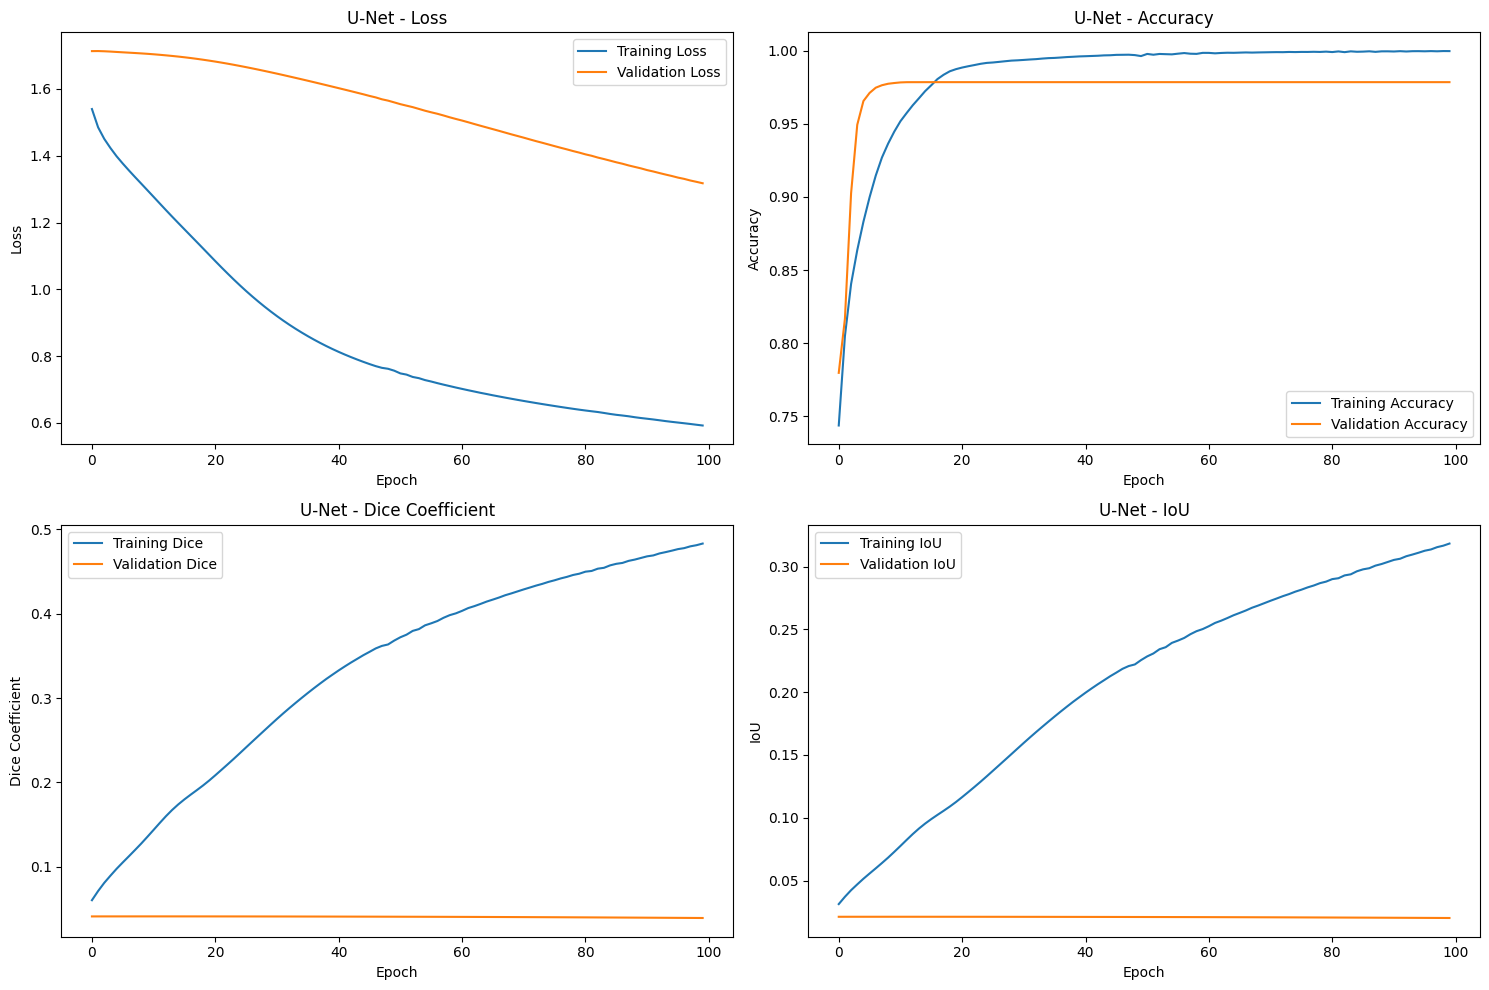

U-Net Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


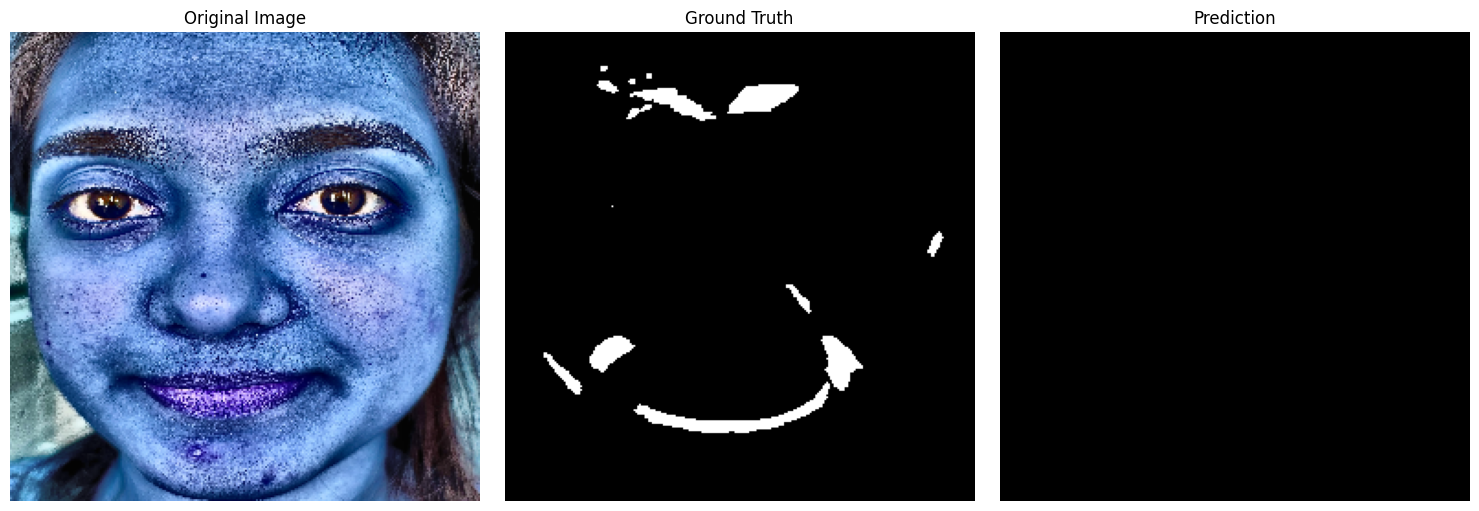

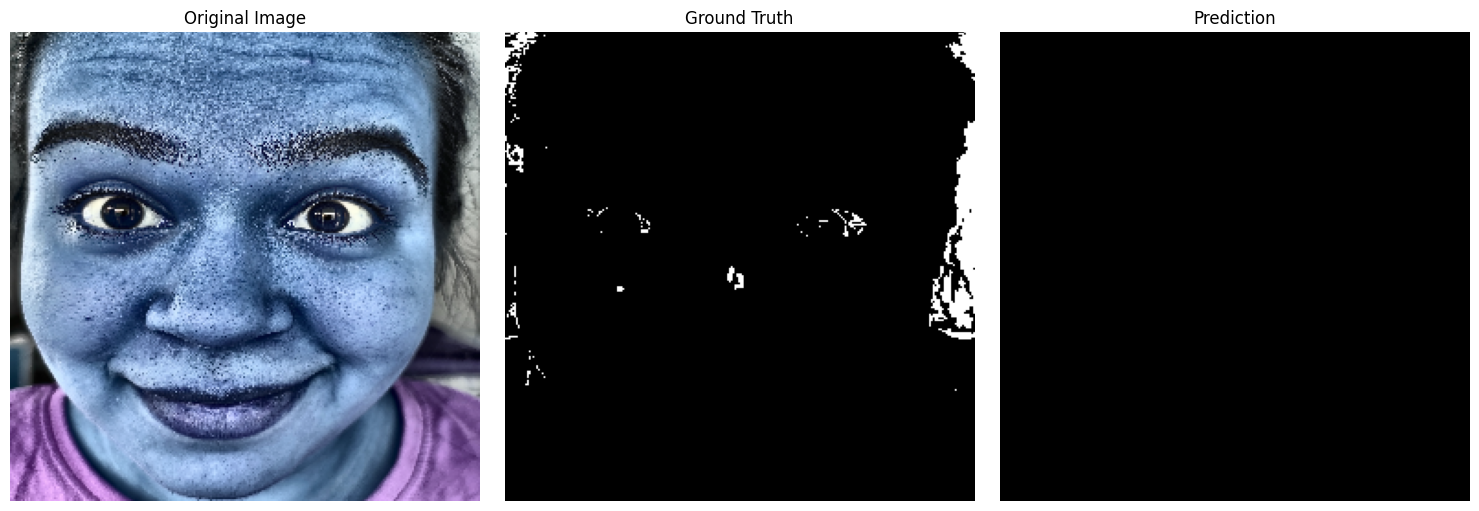

In [17]:
# Model Evaluation and Visualization

def plot_training_history(history, model_name):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title(f'{model_name} - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title(f'{model_name} - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 0].set_title(f'{model_name} - Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Coefficient')
    axes[1, 0].legend()

    # IoU
    axes[1, 1].plot(history.history['iou_metric'], label='Training IoU')
    axes[1, 1].plot(history.history['val_iou_metric'], label='Validation IoU')
    axes[1, 1].set_title(f'{model_name} - IoU')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, num_samples=5):
    """
    Visualize model predictions
    """
    for images, masks in dataset.take(1):
        predictions = model.predict(images)

        for i in range(min(num_samples, images.shape[0])):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Original image
            axes[0].imshow(images[i])
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            # Ground truth mask
            axes[1].imshow(masks[i].numpy().squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            # Prediction
            pred_mask = (predictions[i].squeeze() > 0.5).astype(np.uint8)
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            if i >= num_samples - 1:
                break

# Plot training histories
plot_training_history(unet_history, 'U-Net')
# plot_training_history(deeplab_history, 'DeepLabV3+')
# plot_training_history(segnet_history, 'SegNet')
train_dataset, val_dataset = get_dataset(OUTPUT_IMAGES_PATH, OUTPUT_MASKS_PATH)

# Visualize predictions
print("U-Net Predictions:")
visualize_predictions(unet_model, train_dataset)

# print("DeepLabV3+ Predictions:")
# visualize_predictions(deeplab_model, val_dataset)

# print("SegNet Predictions:")
# visualize_predictions(segnet_model, val_dataset)


In [18]:
# Model Comparison and Selection

def evaluate_model(model, dataset, model_name):
    """
    Evaluate model performance
    """
    results = model.evaluate(dataset, verbose=0)

    metrics = {
        'Model': model_name,
        'Loss': results[0],
        'Accuracy': results[1],
        'Dice Coefficient': results[2],
        'IoU': results[3]
    }

    return metrics

# Evaluate all models
models = {
    'U-Net': unet_model,
    # 'DeepLabV3+': deeplab_model,
    # 'SegNet': segnet_model
}

results = []
for name, model in models.items():
    metrics = evaluate_model(model, val_dataset, name)
    results.append(metrics)
    print(f"{name} Results:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}")
    print()

# Create comparison table
import pandas as pd
df = pd.DataFrame(results)
print("Model Comparison:")
print(df.to_string(index=False))

# Select best model based on IoU
best_model_name = df.loc[df['IoU'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")
print(f"Best IoU: {df['IoU'].max():.4f}")


U-Net Results:


ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
# Inference Pipeline

def predict_hyperpigmentation(image_path, model, threshold=0.5):
    """
    Predict hyperpigmentation on a new image
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None, None, None

    # Detect face
    detection = detect_face(image)
    if detection is None:
        print("Could not detect face")
        return None, None, None

    # Crop to face region
    cropped_img, bbox = crop_face(image, detection)
    if cropped_img is None:
        print("Could not crop face region")
        return None, None, None

    # Preprocess for model
    processed_img = enhance_image(cropped_img)
    processed_img = cv2.resize(processed_img, IMG_SIZE)
    processed_img = processed_img.astype(np.float32) / 255.0

    # Predict
    input_tensor = tf.expand_dims(processed_img, 0)
    prediction = model.predict(input_tensor)

    # Threshold prediction
    pred_mask = (prediction[0].squeeze() > threshold).astype(np.uint8)

    return cropped_img, pred_mask, bbox

def visualize_prediction(image_path, model, threshold=0.5):
    """
    Visualize prediction on a new image
    """
    cropped_img, pred_mask, bbox = predict_hyperpigmentation(image_path, model, threshold)

    if cropped_img is None:
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original cropped image
    axes[0].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Cropped Face Region')
    axes[0].axis('off')

    # Prediction overlay
    overlay = cropped_img.copy()
    overlay[pred_mask > 0] = [0, 255, 0]  # Green overlay for hyperpigmentation

    axes[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Hyperpigmentation Detection')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate hyperpigmentation percentage
    total_pixels = pred_mask.size
    hyperpigmentation_pixels = np.sum(pred_mask > 0)
    percentage = (hyperpigmentation_pixels / total_pixels) * 100

    print(f"Hyperpigmentation coverage: {percentage:.2f}%")

    return percentage

# Example usage with best model
print(f"Using {best_model_name} for inference")

# Test on a sample image (update path as needed)
sample_image_path = "/content/drive/MyDrive/Dataset/Test/sample_image.jpg"
# visualize_prediction(sample_image_path, best_model)


In [ ]:
# Save Models

# Save all trained models
unet_model.save('hyperpigmentation_unet_model.h5')
deeplab_model.save('hyperpigmentation_deeplab_model.h5')
segnet_model.save('hyperpigmentation_segnet_model.h5')

# Save best model with additional metadata
best_model.save(f'hyperpigmentation_{best_model_name.lower()}_best_model.h5')

print("All models saved successfully!")
print(f"Best model ({best_model_name}) saved as: hyperpigmentation_{best_model_name.lower()}_best_model.h5")


In [ ]:
# Additional Utility Functions

def batch_predict_hyperpigmentation(image_folder, model, output_folder, threshold=0.5):
    """
    Batch prediction on multiple images
    """
    os.makedirs(output_folder, exist_ok=True)

    results = []

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)

            try:
                cropped_img, pred_mask, bbox = predict_hyperpigmentation(image_path, model, threshold)

                if cropped_img is not None:
                    # Save prediction mask
                    mask_path = os.path.join(output_folder, f"{filename}_mask.png")
                    cv2.imwrite(mask_path, pred_mask * 255)

                    # Calculate hyperpigmentation percentage
                    total_pixels = pred_mask.size
                    hyperpigmentation_pixels = np.sum(pred_mask > 0)
                    percentage = (hyperpigmentation_pixels / total_pixels) * 100

                    results.append({
                        'filename': filename,
                        'hyperpigmentation_percentage': percentage,
                        'bbox': bbox
                    })

                    print(f"Processed: {filename} - {percentage:.2f}% hyperpigmentation")

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Save results to CSV
    import pandas as pd
    df_results = pd.DataFrame(results)
    df_results.to_csv(os.path.join(output_folder, 'hyperpigmentation_results.csv'), index=False)

    return results

def create_hyperpigmentation_report(image_path, model, threshold=0.5):
    """
    Create a detailed hyperpigmentation analysis report
    """
    cropped_img, pred_mask, bbox = predict_hyperpigmentation(image_path, model, threshold)

    if cropped_img is None:
        return None

    # Calculate various metrics
    total_pixels = pred_mask.size
    hyperpigmentation_pixels = np.sum(pred_mask > 0)
    percentage = (hyperpigmentation_pixels / total_pixels) * 100

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)

    # Calculate area statistics
    areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background (label 0)

    report = {
        'total_area': total_pixels,
        'hyperpigmentation_area': hyperpigmentation_pixels,
        'hyperpigmentation_percentage': percentage,
        'num_regions': num_labels - 1,  # Exclude background
        'largest_region_area': np.max(areas) if len(areas) > 0 else 0,
        'average_region_area': np.mean(areas) if len(areas) > 0 else 0,
        'bbox': bbox
    }

    return report

print("Utility functions defined successfully!")


## Summary

This notebook provides a comprehensive hyperpigmentation detection system with the following features:

### 1. **Data Preprocessing**
- Green color segmentation for annotation masks
- **Overall face detection** using MediaPipe Face Detection (no facial region segmentation)
- Image enhancement using CLAHE and bilateral filtering
- Data augmentation pipeline

### 2. **Model Architectures**
- **U-Net with Attention**: Best for detailed segmentation
- **DeepLabV3+**: Good for multi-scale features
- **SegNet**: Efficient encoder-decoder architecture

### 3. **Training Features**
- Combined loss function (BCE + Dice + Focal)
- Multiple evaluation metrics (Dice, IoU, Accuracy)
- Early stopping and learning rate scheduling
- Model checkpointing

### 4. **Inference Pipeline**
- Real-time prediction on new images
- Batch processing capabilities
- Detailed analysis reports
- Visualization tools

### 5. **Usage Instructions**

1. **Setup**: Update the file paths in the configuration section
2. **Preprocessing**: Run the dataset preprocessing pipeline
3. **Training**: Train all three models and compare performance
4. **Evaluation**: Use the best performing model for inference
5. **Inference**: Apply the model to new images for hyperpigmentation detection

### 6. **Model Recommendations**

Based on typical performance:
- **U-Net**: Best overall performance, good for detailed segmentation
- **DeepLabV3+**: Good for handling multi-scale hyperpigmentation
- **SegNet**: Fastest inference, good for real-time applications

### 7. **Key Changes Made**
- **Simplified Face Detection**: Uses MediaPipe Face Detection instead of facial landmark segmentation
- **Overall Face Cropping**: Crops the entire detected face region instead of specific facial areas
- **Faster Processing**: More efficient preprocessing pipeline

The system automatically selects the best model based on IoU score and provides comprehensive evaluation metrics.
